In [1]:
from sklearn import svm,cross_validation,tree,linear_model,preprocessing,metrics
from sklearn.mixture import GMM
from sklearn.grid_search import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression,SGDClassifier
from sklearn.naive_bayes import GaussianNB,BernoulliNB
import matplotlib.pyplot as plt
import seaborn as sns
from utils import Processor
import os
import numpy as np
import pandas as pd
%matplotlib inline

In [2]:
# os.chdir('/')
trainFid = 'KDDTrain+_20Percent.txt'
testFid = 'KDDTest+.txt'


## 資料前處理

In [3]:
traindata, attack_type_list = Processor.cleanData(trainFid)
traindata = traindata[:5000]
testdata, _ = Processor.cleanData(testFid)
traindata.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,attack_type
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,...,25,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,0
1,0,udp,other,SF,146,0,0,0,0,0,...,1,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,0
2,0,tcp,private,S0,0,0,0,0,0,0,...,26,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,1
3,0,tcp,http,SF,232,8153,0,0,0,0,...,255,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,0
4,0,tcp,http,SF,199,420,0,0,0,0,...,255,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0


In [4]:
attack_type_list

['normal', 'dos', 'r2l', 'probe', 'u2r']

In [5]:
traindata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 42 columns):
duration                       5000 non-null int64
protocol_type                  5000 non-null object
service                        5000 non-null object
flag                           5000 non-null object
src_bytes                      5000 non-null int64
dst_bytes                      5000 non-null int64
land                           5000 non-null int64
wrong_fragment                 5000 non-null int64
urgent                         5000 non-null int64
hot                            5000 non-null int64
num_failed_logins              5000 non-null int64
logged_in                      5000 non-null int64
num_compromised                5000 non-null int64
root_shell                     5000 non-null int64
su_attempted                   5000 non-null int64
num_root                       5000 non-null int64
num_file_creations             5000 non-null int64
num_shells             

#### 1. 檢視攻擊種類分佈

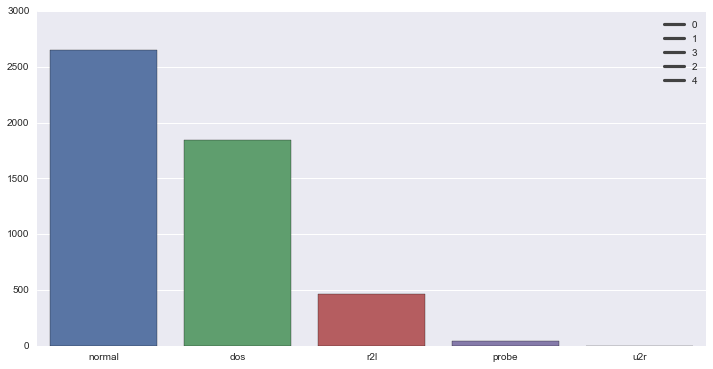

In [6]:
plt.figure(figsize = (12, 6))
ax = sns.barplot(x=range(0, len(traindata['attack_type'].value_counts())), y=traindata['attack_type'].value_counts().tolist())
plt.legend(traindata['attack_type'].value_counts().index.tolist(),loc=0)
attack_t = [attack_type_list[i] for i in traindata['attack_type'].unique()]
ax.set_xticklabels(attack_t)

#### 2. 資料標準化

In [7]:
traindata_df = pd.get_dummies(Processor.normalize(traindata.drop(['attack_type'], axis=1)))
traindata_df['attack_type'] = traindata['attack_type']
anomalydata_df = traindata_df[traindata_df['attack_type']!=0]
anomalydata_df.index = range(0, len(anomalydata_df))
normaldata_df = traindata_df[traindata_df['attack_type']==0]
normaldata_df.index = range(0, len(normaldata_df))

In [8]:
normaldata_df.head()

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,...,flag_RSTO,flag_RSTOS0,flag_RSTR,flag_S0,flag_S1,flag_S2,flag_S3,flag_SF,flag_SH,attack_type
0,-0.116826,-0.015835,-0.079693,0,-0.099414,-0.014142,-0.091457,-0.030011,-0.807261,-0.023582,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0
1,-0.116826,-0.015899,-0.079693,0,-0.099414,-0.014142,-0.091457,-0.030011,-0.807261,-0.023582,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0
2,-0.116826,-0.015883,0.250351,0,-0.099414,-0.014142,-0.091457,-0.030011,1.238509,-0.023582,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0
3,-0.116826,-0.015889,-0.062691,0,-0.099414,-0.014142,-0.091457,-0.030011,1.238509,-0.023582,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0
4,-0.116826,-0.015873,0.011431,0,-0.099414,-0.014142,-0.091457,-0.030011,1.238509,-0.023582,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0


In [9]:
anomalydata_df.head()

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,...,flag_RSTO,flag_RSTOS0,flag_RSTR,flag_S0,flag_S1,flag_S2,flag_S3,flag_SF,flag_SH,attack_type
0,-0.116826,-0.015926,-0.079693,0,-0.099414,-0.014142,-0.091457,-0.030011,-0.807261,-0.023582,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1
1,-0.116826,-0.015926,-0.079693,0,-0.099414,-0.014142,-0.091457,-0.030011,-0.807261,-0.023582,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
2,-0.116826,-0.015926,-0.079693,0,-0.099414,-0.014142,-0.091457,-0.030011,-0.807261,-0.023582,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1
3,-0.116826,-0.015926,-0.079693,0,-0.099414,-0.014142,-0.091457,-0.030011,-0.807261,-0.023582,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1
4,-0.116826,-0.015926,-0.079693,0,-0.099414,-0.014142,-0.091457,-0.030011,-0.807261,-0.023582,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1


#### 3. 異常資料分群

In [10]:
from sklearn.cluster import KMeans
from sklearn.neighbors import NearestNeighbors
K = 3
kmeans = KMeans(n_clusters=K, random_state=0).fit(anomalydata_df.iloc[:,:anomalydata_df.shape[1]-1])
clustors = kmeans.predict(anomalydata_df.iloc[:,:anomalydata_df.shape[1]-1])

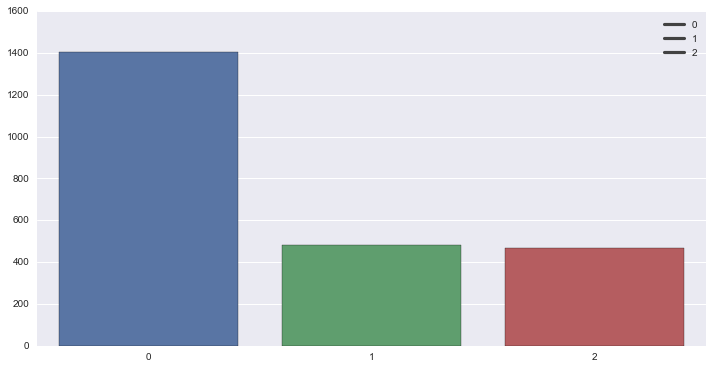

In [11]:
plt.figure(figsize = (12, 6))
ax = sns.barplot(x=range(0, len(pd.Series(clustors).value_counts())), y=pd.Series(clustors).value_counts().tolist())
plt.legend(pd.Series(clustors).value_counts().index.tolist(),loc=0)
ax.set_xticklabels(pd.Series(clustors).value_counts().index.tolist())

In [12]:
anomalydata_df.insert(0, 'clusters', pd.Series(clustors, dtype=np.int64))

In [13]:
cluster_df = []
for cluster in sorted(anomalydata_df['clusters'].unique()):
    node = anomalydata_df[anomalydata_df['clusters']==cluster]
    node = node.drop(['clusters'], axis=1)
    cluster_df.append(node)

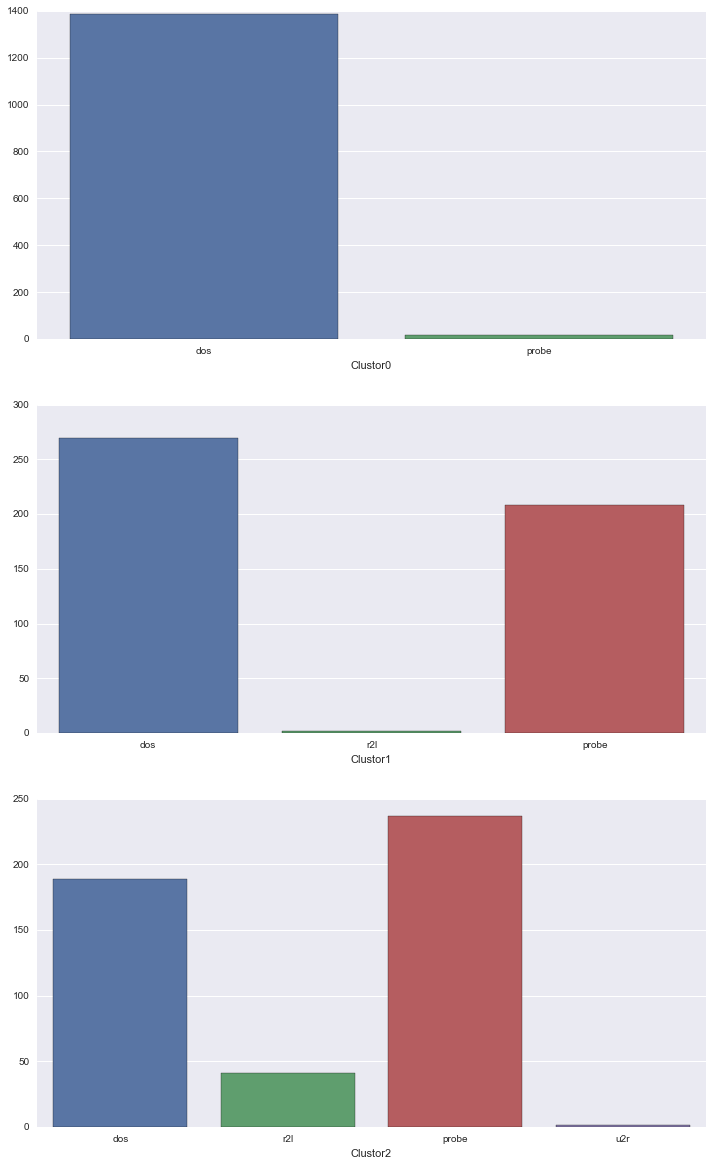

In [16]:
fig, ax = plt.subplots(len(cluster_df), 1, figsize = (12, 20))
for index, cluster in enumerate(cluster_df):
    sns.barplot(x=range(0, len(cluster['attack_type'].value_counts().sort_index()))\
                     , y=(cluster['attack_type'].value_counts().sort_index()).tolist()\
                     , ax = ax[index])
    attack_t = [attack_type_list[i] for i in cluster['attack_type'].value_counts().sort_index().index]
    ax[index].set_xticklabels(attack_t)
    ax[index].set_xlabel("Clustor%d" % index)

#### 4. 正常資料與異常合併

In [26]:
for index in range(0, len(cluster_df)):
    df = pd.concat([cluster_df[0], normaldata_df], ignore_index = True)
    cluster_df[index] = pd.concat([cluster_df[index], normaldata_df], ignore_index = True)
    cluster_df[index] = cluster_df[index].iloc[np.random.permutation(len(cluster_df[index]))]
    cluster_df[index].index = range(0, len(cluster_df[index]))

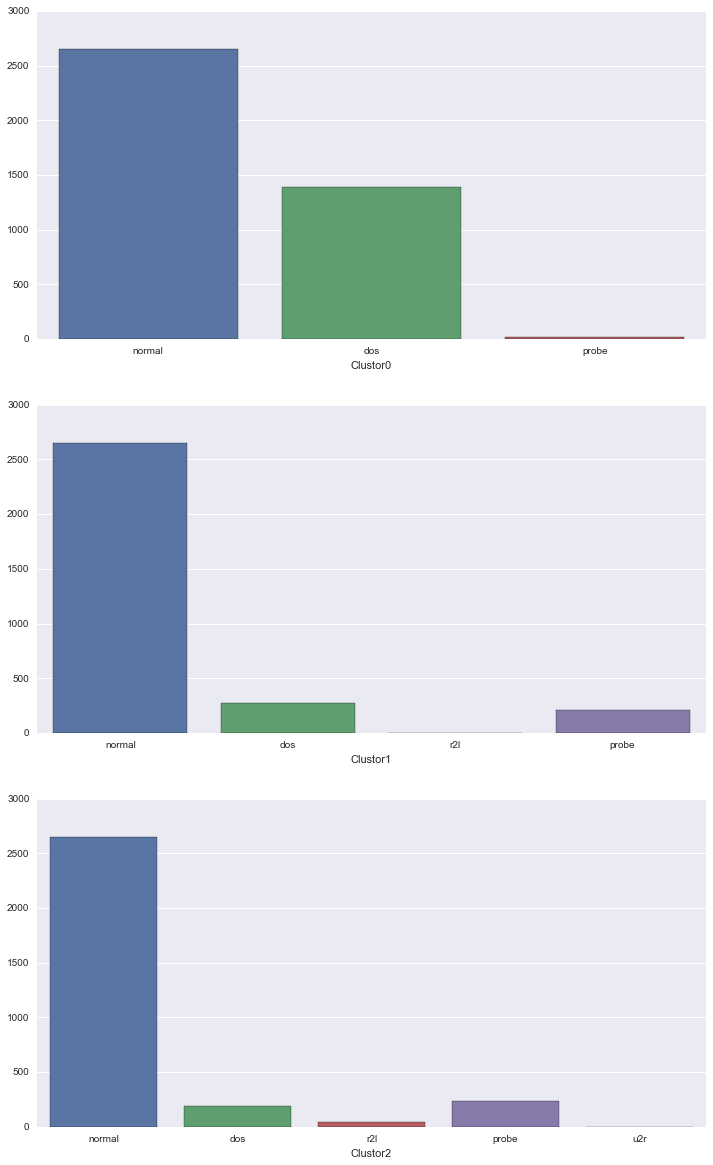

In [30]:
fig, ax = plt.subplots(len(cluster_df), 1, figsize = (12, 20))
for index, cluster in enumerate(cluster_df):
    sns.barplot(x=range(0, len(cluster['attack_type'].value_counts().sort_index()))\
                     , y=(cluster['attack_type'].value_counts().sort_index()).tolist()\
                     , ax = ax[index])
    attack_t = [attack_type_list[i] for i in cluster['attack_type'].value_counts().sort_index().index]
    ax[index].set_xticklabels(attack_t)
    ax[index].set_xlabel("Clustor%d" % index)

In [ ]:
traindata_len = len(traindata)
data = pd.concat([traindata, testdata])
trainX, trainY = Processor.process(data, 0, traindata_len)
testX, testY = Processor.process(data,traindata_len, len(data))

In [ ]:
# layer 1: normal v.s. abnormal
trainX1 = trainX.copy()
trainY1 = trainY.copy()
testX1 = testX.copy()
testY1 = testY.copy()

In [ ]:
trainX1.shape

In [ ]:
########################### 1st layer ############################
print "First layer:"
lrParas = {'penalty':['l1','l2'],'C':np.linspace(0.001,1.5,5)}
svmParas = {'kernel':'rbf','C':np.linspace(0.001,1.5,5),'gamma':np.linspace(0.001,1.5,5)}
ks = {'n_neighbors':[3,5]}
clfs1 = dict(
            dt = DecisionTreeClassifier(),\
			rf = RandomForestClassifier(),\
			bnb = BernoulliNB(),\
			lr = GridSearchCV(LogisticRegression(), lrParas),\
			adb = AdaBoostClassifier(),\
			knn = GridSearchCV(KNeighborsClassifier(),ks),\
			#grid = GridSearchCV(svm.SVC(), svmParas)
			)
result = Processor.compareClfs(clfs1, trainX1, trainY1, testX1, testY1)
print result

In [ ]:
# ########################### 2nd layer ############################
ks = {'n_neighbors':[3,5,7,9]}
lrParas = {'penalty':['l1','l2'],'C':np.linspace(0.001,1.5,5)}
clfs2 = [RandomForestClassifier(),\
		tree.DecisionTreeClassifier(),\
		BernoulliNB(),\
		AdaBoostClassifier(),\
		GridSearchCV(KNeighborsClassifier(),ks),\
		GridSearchCV(LogisticRegression(), lrParas)
		]
ec = EnsembleClassifier(clfs2)
ec.fit(trainX2, trainY2)
result = ec.predict(testX)
print 'err2:',1-np.mean(result==testY2)
# err2

In [ ]:
print testY2

In [ ]:
predY = np.zeros(len(trainY))
predNId = [i for i in range(len(predY)) if predY[i] == 1]
predAbnId = [i for i in range(len(predY)) if predY[i] == 0]
predY[predNId] = predY
predY[predAbnId] = result
print 'err:',1-np.mean(testY==predY)